## Python Core Demo

How to use the python core from a Jupyter notebook. It also shows how to debug the JSON application configs which are used to connect to external database(s) and redis server(s).


In [118]:
import redis
import time 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import base64
import pickle
from collections import defaultdict
rDB = redis.Redis(host='localhost', port=6379, db=0)
# The key under which the list of executable jobs is accessible
FREE_JOBS_KEY = '{0}:free_jobs'
# The Pub/Sub channel where clients report the results of a job execution
JOB_RESULTS_CHANNEL = '{0}:c_results'
# The key from which the id for a new job can be retrieved
JOB_IDS_KEY = '{0}:job_ids'
# The format for the key under which connection information for a slave is saved
SLAVE_KEY = '{0}:slave:{1}'
# The format for the key under which the list of slaves for a server is saved
SLAVE_LIST_KEY = '{0}:slaves'
# The key under which a list of successfully executed jobs is saved
FINISHED_JOBS_KEY = '{0}:finished_jobs'
# The format of block names
BLOCK_NAME_FORMAT = '{0}:{1}:{2}'
# The format of the key where matrix information is saved
INFO_FORMAT         = '{0}:info'
# The format of a matrix name, where argument 0 is a counter and argument 1 a random number
MATRIX_NAME_FORMAT     = 'matrix{0}_{1}'
import numpy as np 
import redis
import math

class Matrix:
    def __init__(self, name, rows, cols, rdb,block_size=256):
        self.__name = name
        self.__rows = rows
        self.__cols = cols
        self.shape = (self.__rows, self.__cols)
        self.__persist = False
        self.rdb = rdb
        self.__block_size = int(block_size)

    def dumps(matrix):
        flat = []
        flat.append(str(matrix.shape[0]))
        flat.append(',')
        flat.append(str(matrix.shape[1]))
        
        zero_count = 0
        for e in matrix.flat:
            if e == 0:
                zero_count += 1
            else:
                if zero_count != 0:
                    if zero_count < 3:
                        for i in range(0,zero_count):
                            flat.append(';0')
                    else:
                        flat.append(';')
                        flat.append('x')
                        flat.append(str(zero_count))
                        
                    zero_count = 0

                flat.append(';')
                flat.append(str(e))
        return ''.join(flat)
        
    def loads(s):
        elements = s.split(';')
        shape = elements[0].split(',')
        width = int(shape[0])
        height = int(shape[1])
        flat = []
        for e in elements[1:]:
            if e[0] == 'x':
                num = int(e[1:])
                for i in range(0,num):
                    flat.append(0)
            else:
                flat.append(float(e))
        return np.reshape(flat, (width, height))

    def create_block(self, block_name, data):
        return self.rdb.set(block_name, data.dumps())

    def get_block(self, block_name):
        return np.loads(self.rdb.get(block_name))
    
    def get_value(self, key):
        return self.rdb.get(key)
        
    def set_value(self, key, value):
        return self.rdb.set(key, value)
     
    def delete_block(self, block_name):
        return self.rdb.delete(block_name)

    def row_blocks(self):
        """
            Returns the number of row blocks this matrix is divided into
        """
        return int(math.ceil(float(self.__rows) / self.__block_size))
        
    def col_blocks(self):
        """
            Returns the number of column blocks this matrix is divided into
        """
        return int(math.ceil(float(self.__cols) / self.__block_size))
    
    def block_name(self, row, col):
        """
            Returns the redis key for the block at the given index
        """
        return BLOCK_NAME_FORMAT.format(self.__name, row, col)
    
    def row_block_names(self, row):
        """
            Returns a list of keys of all blocks in a given row
        """
        result = []
        y = self.row_blocks()
        
        for j in range(0,y):
            result.append(self.block_name(row, j))
        return result
        
    def col_block_names(self, col):
        """
            Returns a list of keys of all blocks in a given column
        """
        result = []
        x = self.col_blocks()
        
        for i in range(0,x):
            result.append(self.block_name(i, col))
        return result
        
    def block_names(self):
        """
            Returns a list with all block keys
        """
        x = self.col_blocks()
        y = self.row_blocks()

        result = []
        for j in range(0,y):
            for i in range(0,x):
                result.append(self.block_name(j, i))
        return result
    
    def is_quadratic(self):
        """
           Returns true if the number of rows equals the number of columns 
        """
        return self.__rows == self.__cols
    
    def set_cell_value(self, row, col, val):
        """
            Sets the value of a single matrix cell
        """
        block_row = int(math.floor(row / self.__block_size))
        block_col = int(math.floor(col / self.__block_size))
        offset_row = row % self.__block_size
        offset_col = col % self.__block_size
        block_name = self.block_name(block_row, block_col)
        block = self.get_block(block_name)
        block[offset_row, offset_col] = val
        self.create_block(block_name, block)
    
    def get_cell_value(self, row, col):
        """
            Returns the value of a single matrix cell
        """
        block_row = int(math.floor(row / self.__block_size))
        block_col = int(math.floor(col / self.__block_size))
        offset_row = row % self.__block_size
        offset_col = col % self.__block_size
        block = self.get_block(self.block_name(block_row, block_col))
        return block[offset_row, offset_col]
    
    def get_numpy_block(self, row, col):
        """
            Returns a block as nump matrix
        """
        return self.get_block(self.block_name(row, col))
        
    def get_numpy_matrix(self):
        """
            Concatenates all blocks of this matrix and returns one big numpy matrix
        """
        m = None
        for row in range(0,self.row_blocks()):
            b = self.get_block(self.block_name(row, 0))
            #print self.block_name(row, 0)
            for col in range(1,self.col_blocks()):
                if row == 0 and col == 0:
                    continue
                #print self.block_name(row, col)
                #print '---'
                n = self.get_block(self.block_name(row, col))
                b = np.concatenate((b, n), axis=1)
            if m is None:
                m = b 
            else:
                m = np.concatenate((m, b))
        return m


def get_numpy(name,loc):
    row,col = rDB.get(loc).split('|')
    return Matrix(name,row,col,rDB).get_numpy_matrix()

In [119]:
import json
import base64

class NumpyEncoder(json.JSONEncoder):

    def default(self, obj):
        """If input object is an ndarray it will be converted into a dict 
        holding dtype, shape and the data, base64 encoded.
        """
        if isinstance(obj, np.ndarray):
            if obj.flags['C_CONTIGUOUS']:
                obj_data = obj.data
            else:
                cont_obj = np.ascontiguousarray(obj)
                assert(cont_obj.flags['C_CONTIGUOUS'])
                obj_data = cont_obj.data
            data_b64 = base64.b64encode(obj_data)
            return dict(__ndarray__=data_b64,
                        dtype=str(obj.dtype),
                        shape=obj.shape)
        # Let the base class default method raise the TypeError
        return json.JSONEncoder(self, obj)
        
def json_numpy_obj_hook(dct):
    """Decodes a previously encoded numpy ndarray with proper shape and dtype.
    :param dct: (dict) json encoded ndarray
    :return: (ndarray) if input was an encoded ndarray
    """
    if isinstance(dct, dict) and '__ndarray__' in dct:
        data = base64.b64decode(dct['__ndarray__'])
        return np.frombuffer(data, dct['dtype']).reshape(dct['shape'])
    return dct

In [120]:
episode_to_index = pickle.loads(rDB.get('e_t_to_i'))
index_to_episode = pickle.loads(rDB.get('e_i_to_t'))
series_to_index = pickle.loads(rDB.get('s_t_to_i'))
index_to_series = pickle.loads(rDB.get('s_i_to_t'))
series_episodes = pickle.loads(rDB.get('series_episodes'))
episode_tags = pickle.loads(rDB.get('e_tags'))
doc_data = pickle.loads(rDB.get('doc_data'))

In [122]:
from bs4 import BeautifulSoup
filtered_data = [BeautifulSoup(d,"html5lib").get_text() for d in doc_data]

In [125]:
n_feats = 10000
tfidf_vec = TfidfVectorizer(input='context',min_df=10,max_df=0.85,max_features=n_feats,stop_words='english',norm='l2')
doc_by_vocab = np.empty([len(episode_to_index),n_feats])
doc_by_vocab = tfidf_vec.fit_transform(filtered_data).toarray()
index_to_vocab = tfidf_vec.get_feature_names()
vocab_to_index = {v:i for i,v in enumerate(index_to_vocab) }

In [126]:
doc_by_vocab.shape

(83216, 10000)

In [127]:
from scipy.sparse.linalg import svds
u, s, v_trans = svds(doc_by_vocab, k=100)

(83216, 100)
(100,)
(100, 10000)


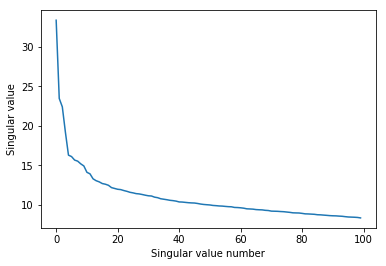

In [128]:
print(u.shape)
print(s.shape)
print(v_trans.shape)
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [129]:
n_users = 1

In [130]:
def set_builder(lst):
    output = []
    for l in lst:
        output+=list(set(l))
    return list(set(output))

In [131]:
index_to_tag = set_builder(episode_tags.values())
n_tags = len(index_to_tag)
tag_to_index = {t:i for i,t in enumerate(index_to_tag)}
episode_tag_matrix = np.zeros([len(index_to_episode),n_tags])
for i in xrange(n_tags):
    for tag in episode_tags[index_to_episode[i]]:
        episode_tag_matrix[i][tag_to_index[tag]] = 1

In [132]:
from keras.layers import Dense, Input, Embedding, Flatten, SimpleRNN, Lambda
from keras.models import Model
from keras.layers.merge import dot
#from keras.losses import mean_squared_error
import keras.backend as K
user_in = Input(shape=(1,), dtype = 'int32')
true_rating_in = Input((1,), dtype = 'float32')
meta_features_in = Input(shape=(doc_by_vocab.shape[1],), dtype = 'float32')

user_embeddings = Embedding(n_users, 8)
user_encoded = Flatten()(user_embeddings(user_in))

episode_encoded = Dense(8)(meta_features_in)
prediction = dot([user_encoded, episode_encoded], axes = 1)
error = Lambda(lambda x: K.mean(K.square(x[0] - x[1]), axis=-1, keepdims = True))
model = Model(inputs = [user_in, meta_features_in,true_rating_in],
                     outputs = error([prediction, true_rating_in]))
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 8)          8                                            
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 10000)         0                                            
____________________________________________________________________________________________________
flatten_7 (Flatten)              (None, 8)             0                                            
___________________________________________________________________________________________

In [142]:
all_cats = list(set(np.hstack([v for k,v in episode_tags.iteritems()])))
from collections import Counter
top_cats_top = [ k for k in sorted(Counter(np.hstack([v for k,v in episode_tags.iteritems()])).items(), key=lambda x:x[1],reverse=True)[:100]]
top_cats = [ k[0] for k in top_cats_top]

In [143]:
# from nltk.corpus import stopwords
# cachedStopWords = stopwords.words("english")

episode_tags_filtered = {k: filter(lambda x: x in top_cats, v) for k, v in episode_tags.iteritems()}

In [145]:
top_cats_top

[('podcast', 5936),
 ('investing', 3276),
 ('market', 3105),
 ('money', 2937),
 ('comedy', 2745),
 ('radio', 2408),
 ('business', 2234),
 ('Podcast', 2130),
 ('stock', 2029),
 ('stocks', 1765),
 ('news', 1762),
 ('retirement', 1758),
 ('fiction', 1705),
 ('financial', 1666),
 ('comics', 1637),
 ('cars', 1604),
 ('automotive', 1594),
 ('Business/Automotive', 1593),
 ('horror', 1528),
 ('the', 1527),
 ('Food', 1524),
 ('management', 1445),
 ('planning', 1404),
 ('Talk Radio', 1299),
 ('podcasts', 1217),
 ('portfolio', 1199),
 ('trading', 1153),
 ('literature', 1149),
 ('John McElroy', 1145),
 ('and', 1134),
 ('comic books', 1097),
 ('finance', 1006),
 ('books', 989),
 ('Show', 977),
 ('investment', 968),
 ('Podcasts', 966),
 ('Comedy', 960),
 ('street', 956),
 ('funny', 945),
 ('skeptic', 916),
 ('time', 910),
 ('of', 905),
 ('wall', 896),
 ('sales', 888),
 ('new', 852),
 ('otr', 840),
 ('poetry', 820),
 ('Fiction', 819),
 ('drama', 802),
 ('deathsquad', 795),
 ('photography', 795),
 ('g

In [157]:
ratings = np.zeros((doc_by_vocab.shape[0],n_users))
# series_name = index_to_series[328]
# series_name2 = index_to_series[444]
# for i in [episode_to_index[e] for e in series_episodes[series_name]]:
#     ratings[i] = 
# for i in [episode_to_index[e] for e in series_episodes[series_name2]]:
#     ratings[i] = 1.0
count = 0
for e in [k for k,v in episode_tags.iteritems() if ('comedy' in v or 'Comedy' in v)]:
    count+=1
    ratings[episode_to_index[e]] = 0.99
users = np.zeros((doc_by_vocab.shape[0],))
labels = np.zeros((doc_by_vocab.shape[0],))

In [159]:
print(users.shape)
print(labels.shape)

print(ratings)
print(count)

(83216,)
(83216,)
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
3534


In [160]:
model.fit([users,doc_by_vocab,ratings],labels,validation_split = .1,epochs=5,verbose=1)

Train on 74894 samples, validate on 8322 samples
Epoch 1/5
74894/74894 [==============================] - 8s - loss: 0.0210 - val_loss: 0.0229
Epoch 2/5
74894/74894 [==============================] - 7s - loss: 0.0193 - val_loss: 0.0226
Epoch 3/5
74894/74894 [==============================] - 6s - loss: 0.0189 - val_loss: 0.0225
Epoch 4/5
74894/74894 [==============================] - 7s - loss: 0.0187 - val_loss: 0.0224
Epoch 5/5
74894/74894 [==============================] - 7s - loss: 0.0186 - val_loss: 0.0224


In [161]:
[index_to_episode[e_i] for e_i in np.array([model.predict([np.array([0]),doc_by_vocab[v].reshape(1,10000),np.array([1.])], batch_size=32, verbose=2)[0][0] for v in range(doc_by_vocab.shape[0])]).argsort()][:10]

['151 - Row, Row, Row Your Boat',
 'OUR FAIR CITY  S3E15',
 'The Flop House: Episode #21 - One Missed Call',
 '#178 The Go In Gomez',
 'The Flop House: Episode #61 - Surrogates',
 'The Geologic Podcast: Episode #47',
 '53 - National Tragedy Special (Kumail Nanjiani)',
 'Laser Time  The Best of 2015 (so far)',
 "#137 Now Who's F*cked?",
 'The Geologic Podcast: Episode #55']

In [257]:
from collections import defaultdict
import string
import re
def regex_parsers_initial(data_string):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    regex_2 = re.compile('[%s]' % re.escape('\n\t'))
    regex_3 = re.compile('[%s]' % '\d+')
    return regex_3.sub(' <NUM> ',regex_2.sub(' ',regex.sub('',data_string.lower())))

def vocabulary(data):
    vocab = defaultdict(int)
    for d in data:
        for k,v in Counter(regex_parsers_initial(d).split(' ')).iteritems():
            vocab[k] += v
    return vocab
filtered_out_words = [ k[0] for k in sorted(vocabulary(filtered_data).items(), key=lambda x:x[1]) if k[1]<5]

In [ ]:
from keras.layers import Dense, Input, Embedding, Flatten, Dropout, Bidirectional, GRU, LSTM
from keras.models import Model
from keras.layers.merge import dot
from keras.layers.pooling import AveragePooling1D
from keras.losses import mean_squared_error
from keras.regularizers import l2 as l2reg

user_in = Input(shape=(1,), dtype = 'int32')
true_rating_in = Input((1,), dtype = 'float32')
meta_features_in = Input(shape=(doc_by_vocab.shape[1],), dtype = 'float32')
#########
user_embeddings = Embedding(n_users, 5)
user_encoded = Flatten()(user_embeddings(user_in))
#########
episode_embeddings = Embedding(vocab_size,300,embeddings_regularizer=l2reg(0.01),weights=[word2vec_mat])
episode_first_dropout = Dropout(0.1)(episode_embeddings)
episode_post_gru = GRU(300)(episode_first_dropout)
# episode_post_first_rnn = Bidirectional(GRU(400))(episode_first_dropout)
# episode_second_dropout = Dropout(0.5)(episode_post_first_rnn)
# episode_post_second_rnn = GRU(units=200)(episode_second_dropout)
# episode_third_dropout = Dropout(0.3)(episode_post_second_rnn)
# episode_encoded_final = AveragePooling1D()(episode_third_dropout)
episode_final = Dense(5)(episode_post_gru)

prediction = dot([user_encoded, episode_encoded], axes = 1)
error = Lambda(lambda x: K.mean(K.square(x[0] - x[1]), axis=-1, keepdims = True))
model = Model(inputs = [user_in, meta_features_in,true_rating_in],
                     outputs = error([prediction, true_rating_in]))
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()